In [80]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn.datasets import load_iris, make_classification
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

In [61]:
def get_true_KNN(x_trn, x_tst):
    N = x_trn.shape[0]
    N_tst = x_tst.shape[0]
    x_tst_knn_gt = np.zeros((N_tst, N))
    for i_tst in tqdm(range(N_tst)):
        dist_gt = np.zeros(N)
        for i_trn in range(N):
            dist_gt[i_trn] = np.linalg.norm(x_trn[i_trn, :] - x_tst[i_tst, :], 2)
        x_tst_knn_gt[i_tst, :] = np.argsort(dist_gt)
    return x_tst_knn_gt.astype(int)


def compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_tst_knn_gt, y_tst, K):
    N = x_trn.shape[0]
    N_tst = x_tst_knn_gt.shape[0]
    sp_gt = np.zeros((N_tst, N))
    for j in tqdm(range(N_tst)):
        sp_gt[j, x_tst_knn_gt[j, -1]] = (y_trn[x_tst_knn_gt[j, -1]] == y_tst[j]) / N
        for i in np.arange(N - 2, -1, -1):
            sp_gt[j, x_tst_knn_gt[j, i]] = sp_gt[j, x_tst_knn_gt[j, i + 1]]
            sp_gt[j, x_tst_knn_gt[j, i]] += (int(y_trn[x_tst_knn_gt[j, i]] == y_tst[j]) - int(y_trn[x_tst_knn_gt[j, i + 1]] == y_tst[j])) / K * min([K, i + 1]) / (i + 1)
    return sp_gt

In [101]:
# x, y = load_iris(return_X_y=True, as_frame=False)

n_samples = 1_000
x, y = make_classification(n_samples=n_samples, )

x_trn, x_tst, y_trn, y_tst = train_test_split(x, y, train_size=.8, test_size=.2, shuffle=True, stratify=y, random_state=3407)
x_trn, x_val, y_trn, y_val = train_test_split(x_trn, y_trn, train_size=.75, test_size=.25, shuffle=True,  stratify=y_trn, random_state=3407)

In [102]:
K = int(n_samples * .01) # 1%

x_val_knn_gt = get_true_KNN(x_trn, x_val)
val_sp_gt = compute_single_unweighted_knn_class_shapley(x_trn, y_trn, x_val_knn_gt, y_val, K)

100%|██████████| 200/200 [00:00<00:00, 312.93it/s]


In [103]:
g_values = np.mean(val_sp_gt, axis=0)
count = int(len(x_trn)*4/5)
interval = int(count*0.02)
x = np.arange(0, count, interval)/len(x_trn)
g_acc_scores = []
g_acc_scores_val = []
idxs = np.argsort(g_values)
keep_idxs = idxs.tolist()
for _ in range(0, count, interval):
    if len(keep_idxs) == len(x_trn):
        x_train_keep, y_train_keep = x_trn, y_trn
    else:
        x_train_keep, y_train_keep = x_trn[keep_idxs], y_trn[keep_idxs]
    clf = RandomForestClassifier(n_jobs=-1, random_state=3407)
    clf.fit(x_train_keep, y_train_keep)
    acc_score = clf.score(x_tst, y_tst)
    acc_score_val = clf.score(x_val, y_val)
    g_acc_scores.append(acc_score)
    g_acc_scores_val.append(acc_score_val)
    keep_idxs = keep_idxs[interval:]

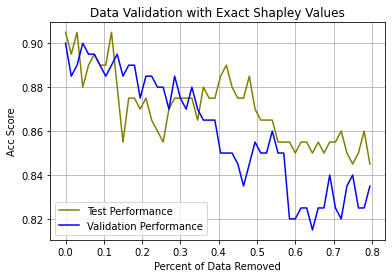

In [104]:
plt.plot(x, g_acc_scores, '-', label='Test Performance', color='olive')
plt.plot(x, g_acc_scores_val, '-', label='Validation Performance', color='blue')
plt.ylabel('Acc Score')
plt.xlabel('Percent of Data Removed')
plt.legend(loc="lower left")
plt.title('Data Validation with Exact Shapley Values')
plt.grid(True)
plt.show()

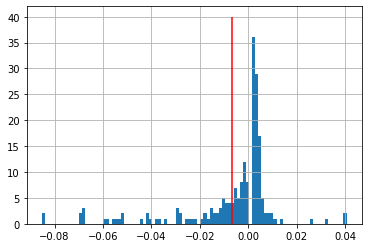

In [119]:
idx = idxs[0]

plt.hist(val_sp_gt.T[idx, :], bins=100)
plt.vlines(g_values[idx], ymin=0, ymax=40, color="red")
plt.grid(True)
plt.show()

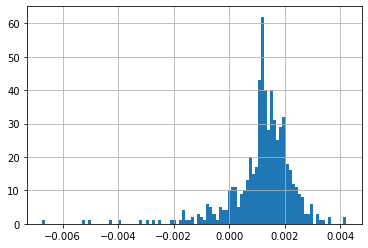

In [117]:
plt.hist(g_values, bins=100)
plt.grid(True)
plt.show()